# Robust Angular Diameters in Python (`RADPy`) : Batch Mode Tutorial

## Introduction to `RADPy`

`RADPy` stands for Robust Angular Diameters in Python. This was created to allow for multi-wavelength fits for angular diameters of stars measured with interferometric methods. Currently `RADPy` only has compatibility with the instruments on the Center for High Angular Resolution Astronomy (CHARA) Array. `RADPy` is currently configured for the following instruments at CHARA:

- Classic/CLIMB
- PAVO
- VEGA
- MIRC-X (in progress)

The remaining CHARA instruments SPICA and MYSTIC will be integrated soon.

## What does `RADPy` actually do?
`RADPy` accepts data from an arbitrary number of beam-combiners from CHARA and allows the user to fit for the angular diameters (both uniform disk and limb-darkened disk) of single stars. With the fitted angular diameter, the user can also calculate the remaining fundamental stellar parameters of effective temperature, stellar luminosity, and radius of the measured star. The user can also plot the interferometric data with the chosen angular diameter fit (uniform or limb-darkened) which will output a publication ready plot. The plotting is highly customizable to the user's needs, including the type of model plotted, the ability to add the diameter in text to said plot, the binning of the data if the user choses to, and more. 

The core of `RADPy` is a Monte Carlo simulation that involves a custom-built bracket bootstrapping within. A bracket in the realm of interferometry describes a set of data taken at the same time. Several instruments at CHARA span a wavelength range, so for every one observation, there is a span of data points to cover the wavelength ranges. `RADPy` automatically assigns a bracket number to the data once the data files are read in. The bracket numbers are assigned based on time-stamp and for PAVO, based on the same UCOORD and VCOORD measurements (as PAVO data does not output a time stamp). 

For uniform disk diameters, `RADPy` will sample the wavelength of observations on a normal distribution. Within the bracket bootstrapping, the visibilities of each bracket chosen to be fit are sampled on a normal distribution. Using lmfit, the data are then fit using the uniform disk visibility squared equation. The final output results in a list of angular diameters calculated. The final uniform disk diameter is determined by taking the average of the uniform disk diameters and the error is determined by taking the mean absolute deviation. 

For limb-darkened disk diameters, `RADPy` follows a similar structure to the uniform disk diameters. There are a few differences which I'll highlight below:

- One needs the limb-darkening coefficient. To account for the limb-darkening coefficient, the tables of limb-darkening coefficients determined by Claret et al. 2011 are used. Based on the observation band, surface gravity (log g), and the effective temperature (Teff) of the star, `RADPy` will use an interpolated function based on the Claret tables to calculate the limb-darkening coefficient. If the effective temperature is less than 3500 and the surface gravity is between 3.5 and 5, the tables with the PHOENIX models are used. For all other stars, the tables with the ATLAS models are used.
- For each iteration of the MC, `RADPy` calculates a limb-darkening coefficient for each band used (i.e. R-band). Within the bootstrapping, `RADPy` samples the limb-darkening coefficient on a normal distribution using 0.02 has the "error". The limb-darkening coefficient is then used in the full visibility squared equation and the limb-darkened angular diameter is fit.
- To ensure `RADPy` is fitting for the optimal angular diameter, the limb-darkened disk fitting function will iterate until minimal change between the previous angular diameter and the one just calculated is seen. For robustness, the effective temperature is also checked as well. Minimal change is defined as being less than or equal to 0.05% difference.

## What is in this notebook?

This tutorial is designed to show you how to use `RADPy`'s `batch_mode()`. This is useful for those that have multiple stars they would like to fit at once or for those that do not want to go through the process step by step. 

## Usage

If you do use this package, please use the following citation:

## Contact
- Ashley Elliott (aelli76@lsu.edu)

## Resources
Link to the github repository (currently private but will be made public soon once documentation is finished): <https://github.com/spaceashley/radpy>


# If you haven't installed `RADPy` yet:
## To install:

**Please pay careful attention to this!!**

Simply use pip to install `RADPy`. Due to naming conflicts, to install `RADPy`, you must use "rsadpy". 

`pip install rsadpy`

The installation should also install all necessary additional packages you need to run everything. Just in case, here is a list of all the necessary packages that aren't default:
- `lmfit`
- `astropy`
- `astroquery`
- `gaiadr3-zeropoint`

To test if the installation worked, import `RADPy`. If you did not get an error, you should be all set. 

`import radpy`

NOTE: 

to _install_, use rsadpy. **Note the 's'**

to _import_, use radpy. **Note that there is no longer an s**

## Step 1: Set-up your input file and your directories

Now that you've installed `RADPy`, we need to set up two things: 

1. Your data directory
2. Your input file

### How to set up your data directory

Create a directory where all of your data files will be kept. All data for all the stars you are fitting will be in this directory. This directory can be named whatever you like, just make note of it. 

Within your data directory, each data file needs to have two things in its name:

1. the name of the instrument
2. the name of the star

The naming structure of your data files should have the name of the instrument in all caps at the beginning of the file and then the star Id at the end before the file extension. The ID should be formatted with an underscore after the catalog identifier. 

For example:

GJ 891 -> GJ_892

HD 219134 -> HD_219134

So the file names should look something like these:

'PAVO_output_HD_219134' or 'SPICA_01_2025-06-11T11-16-21_HD_219134.fits' 

As long as the instrument name is in all caps at the beginning and the star ID is at the very end after an underscore, you should be all set. 

### How to set up your input file

The input file tells `RADPy` what stars you want fitted and the necessary parameters needed for each star. 

You need to compile the following:
1. Star ID, preferrably HD but others work
2. Bolometric flux and error in units of 10^-8 ergs/cm^2/s
3. logg and error in units of dex
4. [Fe/H] and error in units of dex

The input file should have the following column labels:
Star: star IDs
fbol: bolometric flux
dfbol: bolometric flux error
logg: log of surface gravity
dlogg: logg error
feh: [Fe/H]
dfeh: [Fe/H] error

The text file needs to be **tab**-delimited. See example file labeled 'radpy_params_test.txt' in the data directory in the example.

Once your file is created, save it as a **text** file and place it in the same directory as your data files. 

Now you should be all set!

## Step 2: Lets get it running.

You need to first import the function `batch_mode` using the following line:

`from radpy.batchmode import batch_mode`

Now, set up your directory variables and your file names. 
```
data_dir = "C:Path\to\your\data\directory"
output_dir = "C:Path\to\your\data\directory"
param_file = "<name_of_file.txt>"
latex_out = "<name_of_latex_file.tex>"
```

We are all set to begin running `batch_mode`.

In [15]:
import os
import re
def find_files_for_star(star_id, data_dir):
    ignore_ext = {'.jpg', '.jpeg', '.png', '.pdf', '.eps', '.gif', '.tif', '.tiff', '.bmp'}
    pattern = re.compile(rf'_{star_id}\b')  # underscore, then star_id, then word boundary
    matches = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            ext = os.path.splitext(file)[1].lower()
            if pattern.search(file) and ext not in ignore_ext:
                matches.append(os.path.join(root, file))
    return matches


In [17]:
find_files_for_star(10697, datadir)

['C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\Test2\\PAVOoutput_10697']

In [1]:
from radpy.batchmode import batch_mode

In [6]:
datadir = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\Test2"
param_file = "radpy_params_test.txt"
outputdir = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\Test2"
latex_out = "Test_results.tex"

## `batch_mode()`

The inputs to `batch_mode()` are as follows:

|Parameter                       | What is it?                                                       | Example Syntax                          |
|--------------------------------|:-----------------------------------------------------------------:|-----------------------------------------|
|`star_file`                     | File containing your stars and their associated parameters        | `star_file = param_file`                |
|`data_dir`                      | Path to your data directory                                       | `data_dir = data_dir`                   |
|`output_dir`                    | Path to your output directory                                     | `output_dir = output_dir`               |
|                                | Generally should be the same as your data directory               |                                         |
|`latex_out`                     | File name for your latex file                                     | `latex_out = "<name_of_latex_file.tex>"`|
|`mc_num`                        | Number of Monte Carlo iterations you would like                   | `mc_num = 10`                           |
|                                | Default is 71                                                     |                                         |
|`bs_num`                        | Number of bootstrap iterations you would like                     | `bs_num = 10`                           |
|                                | Default is 71                                                     |                                         |
|`set_axis`                      | If set, all plots will have the same axis range                   | `set_axis = [xmin, xmax, ymin, ymax]`   |
|                                | Default is `None`, will assign automatically                      |                                         |
|`image_ext`                     | Set the image file extension you would like to save your plots as | `image_ext = '.jpg'`                    |
|                                | Options: `'.jpg'`, `'.png'`, `'.pdf'`, or `'.eps'`                |                                         |
|`binned`                        | Set which data sets you'd like to be binned for plotting          | `binned = ['pavo']`                     |
|                                | Defaults to `None`, but if set, please use the instrument name.   |                                         |
|`ldc_band`                      | Sets which limb-darkening coefficent you'd like to use            | `ldc_band = 'ldc_R'`                    |
|                                | Options: `'ldc_R'`, `'ldc_K'`, `'ldc_H'`, or `'ldc_J'`            |                                         |
|`verbose`                       | If set, will print out the results of the fitting modules.        | `verbose = True`                        |
|                                | Default is set to `True`                                          |                                         |

To use `batch_mode()`, call the function and attach the necessary inputs. The following inputs are required:
- `star_file`
- `data_dir`
- `out_put`
- `latex_out`

Everything else is optional or has default assignments. 

The ouput of the function if `verbose = True` (the default setting) will display print statements letting you follow along the steps the program is on. It will output the stellar angular diameters as they are fit, the stellar parameters once calculated, and the plots made. 

The output will also save all of your plots to the output directory.

A LaTeX table will also be generated and saved in the same directory as your output directory under the name you gave the function. 

Happy fitting!

--------------------------------------------------
Starting processing for HD 1461
Number of brackets: 5
Found Gaia DR3 ID: Gaia DR3 2430102808294101760
Corrected parallax: 42.6953 [mas]
Distance: 23.42178 +/- 0.01638 [pc]
Initial fit with lmfit:
[[Model]]
    Model(UDV2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 115
    # variables        = 1
    chi-square         = 114.841334
    reduced chi-square = 1.00738012
    Akaike info crit   = 1.84122456
    Bayesian info crit = 4.58615668
    R-squared          = -16.7096188
[[Variables]]
    theta:  0.43157339 +/- 0.00179408 (0.42%) (init = 0.4)
Effective temperature: 5796.29259 +/- 73.44402 K
LDC for filter  R : 0.58237
Initial fit with lmfit:
[[Model]]
    Model(V2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 115
    # variables        = 1
    chi-square         = 114.045304
    reduced chi-square = 1.00039740
    Ak

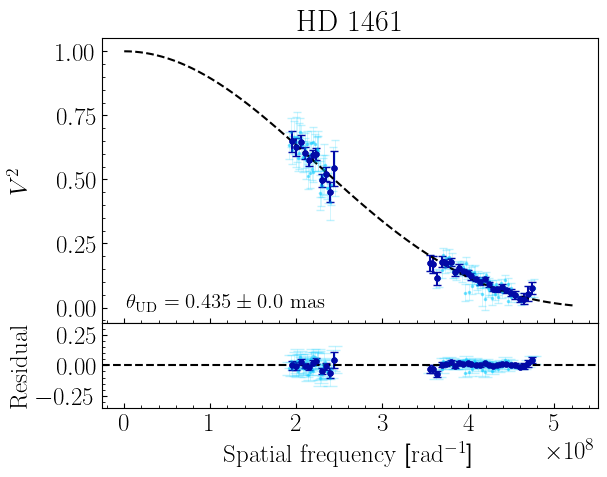

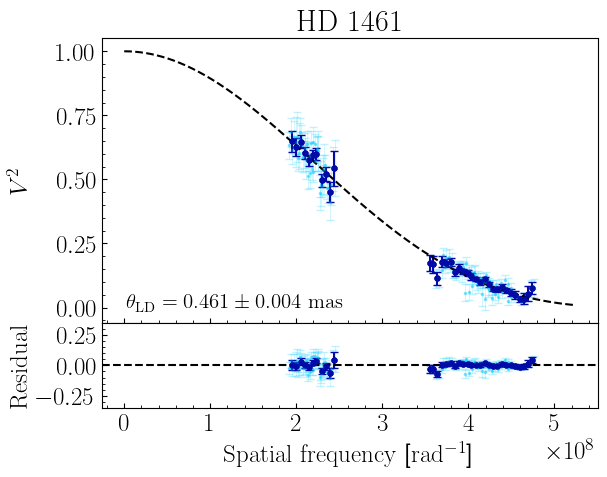

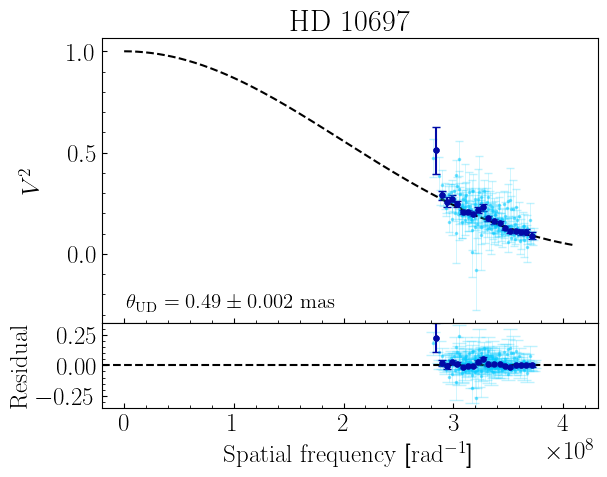

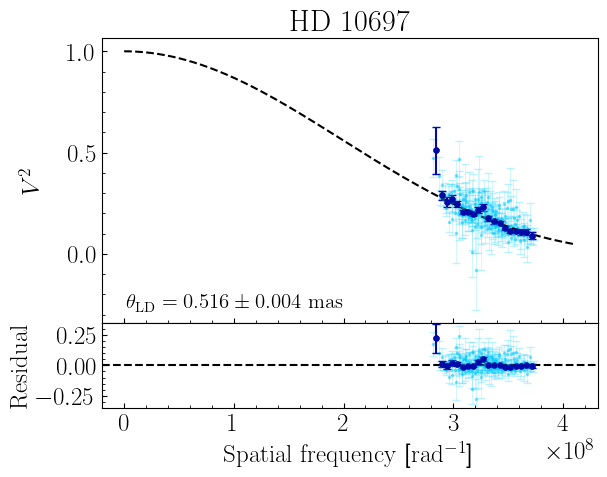

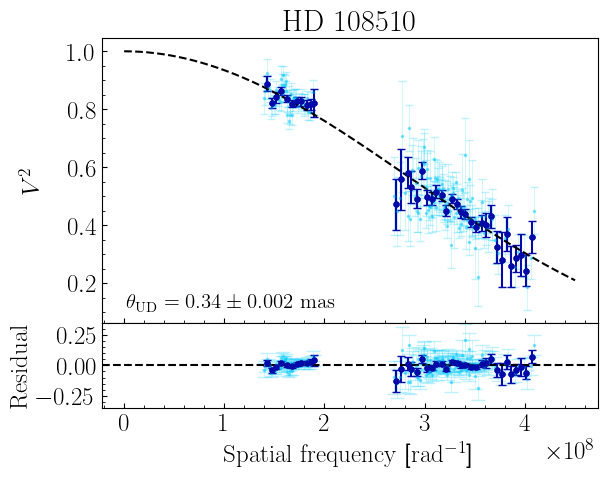

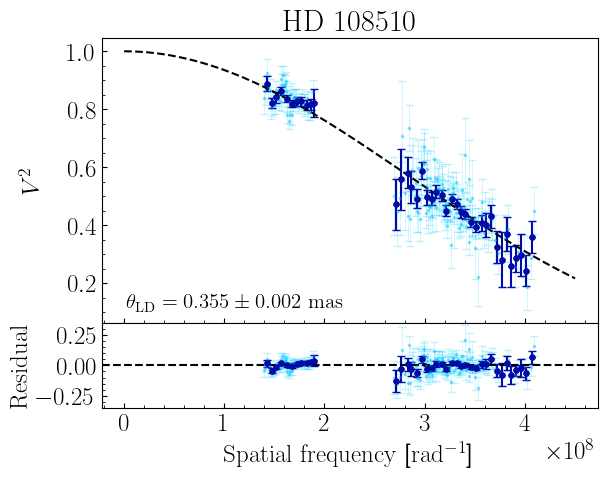

In [3]:
batch_mode(param_file, datadir, outputdir, latex_out, mc_num = 2, bs_num = 2, 
           image_ext = '.jpg', binned = ['pavo'], ldc_band = 'ldc_R')